#  Track Analysis

In order to properly analyze our GPX tracks, we need to put all of them into the same _frame-of-reference_.   This is accomplished by creating a single route, then comparing all routes against that.

## Step 0: Globals

In [1]:
database_path = 'bike_data.db'

start_coord = (39.5989743, -104.8609468)
end_coord   = (39.75428108249532, -105.00085402872664)

epsg_code = 32613

## Step 1: Import Required Libraries

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from pyproj import CRS, Proj, Transformer
import re, numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib as mpl
from matplotlib import cm
import os, shutil

### Step 2: Setup the database.

In [3]:
# SQLAlchemy connectable 
conn = create_engine( 'sqlite:///' + database_path ).connect()

#  For each segment, we need to create a track for each dataset
dataset_ids = pd.read_sql_query('SELECT DISTINCT datasetId FROM point_list', conn)

#  Load the Vertex List
vtx_list = pd.read_csv('waypoints.csv')

#df.loc[df[‘Color’] == ‘Green’]

### Step 3: Setup UTM Coordinate Projection API

In [4]:
#  Setup the Projection Transformer
crs = CRS.from_epsg( epsg_code )
proj_dd2utm = Transformer.from_crs(crs.geodetic_crs, crs)
proj_utm2dd = Transformer.from_crs(crs, crs.geodetic_crs)
utm_zone = int(re.findall("\d+", crs.utm_zone)[0])
print('UTM Grid Zone: {}'.format(utm_zone))

(easting,northing) = proj_dd2utm.transform( start_coord[0], start_coord[1] )
start_coord_utm = np.array( [easting, northing], np.float64 )

UTM Grid Zone: 13


## Step 4: Visualize "Best-Fit" Routes from the GA

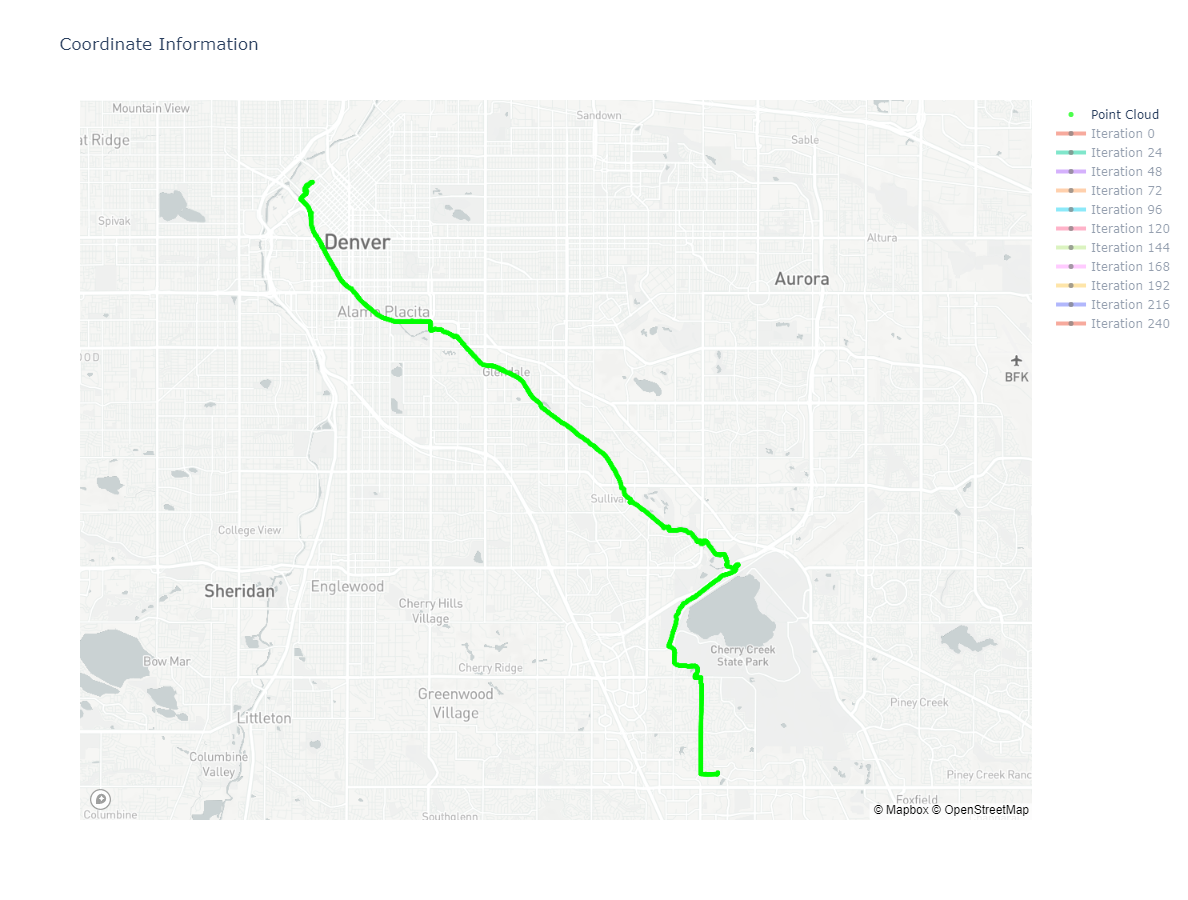

In [5]:
mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure()

#  Add Points
sql_query = 'SELECT * FROM point_list ORDER BY timestamp'
full_points = pd.read_sql_query( sql_query, conn )
fig.add_trace(go.Scattermapbox(
        lat=full_points.loc[:,'latitude'],
        lon=full_points.loc[:,'longitude'],
        mode='markers',
        name='Point Cloud',
        marker=go.scattermapbox.Marker( size=5,
                                        color='rgb(0, 255, 0)',
                                        opacity=0.7 )
    ))

centroid = [full_points.loc[:,'latitude'].mean(),
            full_points.loc[:,'longitude'].mean()]
fig.update_layout(
    title='Coordinate Information',
    autosize=True,
    hovermode='closest',
    showlegend=True,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=centroid[0],
            lon=centroid[1]
        ),
        pitch=0,
        zoom=11,
        style='light'
    ),
    height=900,
)

#  Get the list of waypoint sizes
iterations = vtx_list['Iteration'].unique()
iter_size = int(iterations[-1]/10)
if len(iterations) > 10:
    iterations = iterations[0::iter_size]

cmap = mpl.cm.get_cmap('Spectral')
for iteration in iterations:
    
    #  Assign a color
    color = 0
    if len(iterations) > 0 or (iterations.max() - iterations.min()) < 0.1:
        color = cmap((iteration - iterations.min()) / (iterations.max() - iterations.min()))
    
    #  Add the trace
    vtx_iter = vtx_list.loc[vtx_list['Iteration'] == iteration]
    fig.add_trace( go.Scattermapbox( lat=vtx_iter['Latitude'],
                                     lon=vtx_iter['Longitude'],
                                     mode='markers+lines',
                                     line=dict(width=4),
                                     name='Iteration ' + str(iteration),
                                     visible='legendonly',
                                     marker=go.scattermapbox.Marker( size=5,
                                                                     color=color,
                                                                     opacity=0.7 )))

fig.show()

## Step 5: Construct Time-Lapse Image



In [6]:
#  Get the list of waypoint sizes
iterations = vtx_list['Iteration'].unique()
cmap = mpl.cm.get_cmap('Spectral')
centroid = [full_points.loc[:,'latitude'].mean(),
            full_points.loc[:,'longitude'].mean()]
#  Assign a color
color = 0
if len(iterations) > 0 or (iterations.max() - iterations.min()) < 0.1:
    color = cmap((iteration - iterations.min()) / (iterations.max() - iterations.min()))

#  Wipe out figure directory
#shutil.rmtree('./frames')
#os.makedirs('./frames')


for iteration in iterations:
    
    image_pathname = 'frames/frame_' + str(iteration).zfill(4) + '.png'
    if os.path.exists( image_pathname ):
        print('Frame ' + image_pathname + ' already exists')
        continue
        
    fig2 = go.Figure()

    #  Add Points
    fig2.add_trace(go.Scattermapbox( lat=full_points.loc[:,'latitude'],
                                     lon=full_points.loc[:,'longitude'],
                                     mode='markers',
                                     name='Point Cloud',
                                     marker=go.scattermapbox.Marker( size=5,
                                                                     color='rgb(0, 255, 0)',
                                                                     opacity=0.7 )))

    fig2.update_layout( title='Iteration ' + str(iteration),
                        autosize=True,
                        hovermode='closest',
                        showlegend=False,
                        mapbox=dict( accesstoken=mapbox_access_token,
                                     bearing=0,
                                     center=dict( lat=centroid[0],
                                                  lon=centroid[1] ),
                        pitch=0,
                        zoom=11,
                        style='light' ),
                        height=900,
                      )
    
    
    
    #  Add the trace
    vtx_iter = vtx_list.loc[vtx_list['Iteration'] == iteration]
    fig2.add_trace( go.Scattermapbox( lat=vtx_iter['Latitude'],
                                     lon=vtx_iter['Longitude'],
                                     mode='markers+lines',
                                     line=dict(width=4),
                                     name='Iteration ' + str(iteration),
                                     marker=go.scattermapbox.Marker( size=5,
                                                                     color=color,
                                                                     opacity=0.7 )))

    print('Writing: ' + image_pathname)
    fig2.write_image( image_pathname, engine="kaleido" )


Frame frames/frame_0000.png already exists
Frame frames/frame_0001.png already exists
Frame frames/frame_0002.png already exists
Frame frames/frame_0003.png already exists
Frame frames/frame_0004.png already exists
Frame frames/frame_0005.png already exists
Frame frames/frame_0006.png already exists
Frame frames/frame_0007.png already exists
Frame frames/frame_0008.png already exists
Frame frames/frame_0009.png already exists
Frame frames/frame_0010.png already exists
Frame frames/frame_0011.png already exists
Frame frames/frame_0012.png already exists
Frame frames/frame_0013.png already exists
Frame frames/frame_0014.png already exists
Frame frames/frame_0015.png already exists
Frame frames/frame_0016.png already exists
Frame frames/frame_0017.png already exists
Frame frames/frame_0018.png already exists
Frame frames/frame_0019.png already exists
Frame frames/frame_0020.png already exists
Frame frames/frame_0021.png already exists
Frame frames/frame_0022.png already exists
Frame frame